# Redfin revisited--Puting your model to test

In [1]:
%matplotlib notebook
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

import catboost as cgb
import xgboost as xgb
import lightgbm as lgb

### I have pre-processed the redfin data.

keeping only the single family residential houses, filling missing values either 0 for continuous or "unknown" for categorical features, particular the missing values in walkscore, bikescore, and transitscore are filled with mean score for the same zip area. There are two new features created from "property history records", days from last sale, and number of historical records.

In [2]:
redfin = pd.read_csv('redfin_processed-1.csv',parse_dates=['SOLD DATE'])

In [3]:
redfin_test = pd.read_csv('redfin_test_processed.csv',parse_dates=['SOLD DATE'])

In [4]:
redfin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7314 entries, 0 to 7313
Data columns (total 26 columns):
SOLD DATE              7314 non-null datetime64[ns]
zip                    7314 non-null int64
PRICE                  7314 non-null int64
BEDS                   7314 non-null int64
BATHS                  7314 non-null float64
SQUARE FEET            7314 non-null int64
LOT SIZE               7314 non-null int64
YEAR BUILT             7314 non-null int64
HOA/MONTH              7314 non-null int64
propertyStyle          7314 non-null object
garageCap              7314 non-null int64
parkingCap             7314 non-null int64
driveway               7314 non-null object
roof                   7314 non-null object
patio                  7314 non-null int64
hasPool                7314 non-null object
taxdue                 7314 non-null int64
frontFaceDirection     7314 non-null object
yearRemodled           7314 non-null int64
propertyHistory        7314 non-null object
schoolserving   

In [5]:
redfin_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 28 columns):
level_0                516 non-null int64
index                  516 non-null int64
SOLD DATE              516 non-null datetime64[ns]
zip                    516 non-null float64
PRICE                  516 non-null int64
BEDS                   516 non-null float64
BATHS                  516 non-null float64
SQUARE FEET            516 non-null float64
LOT SIZE               516 non-null float64
YEAR BUILT             516 non-null float64
HOA/MONTH              516 non-null float64
propertyStyle          516 non-null object
garageCap              516 non-null int64
parkingCap             516 non-null int64
driveway               516 non-null object
roof                   516 non-null object
patio                  516 non-null int64
hasPool                516 non-null object
taxdue                 516 non-null int64
frontFaceDirection     516 non-null object
yearRemodled           516 

In [6]:
redfin['propertyHistory'][1000]

"[('Sold (MLS)', 1493362800000), ('Pending', 1491341332920), ('Price Changed', 1489477470000), ('Listed', 1488851879646), ('Delisted', 1195027200000), ('Delisted', 1179173115000), ('Listed', 1179126000000), ('Listed', 1176274800000), ('Sold (MLS)', 947145600000), ('Listed', 945072000000), ('Sold (MLS)', 851328000000), ('Listed', 848908800000)]"

In [7]:
redfin['sold_year'] = redfin['SOLD DATE'].dt.year
redfin['sold_month'] = redfin['SOLD DATE'].dt.month
redfin['sold_day'] = redfin['SOLD DATE'].dt.day

### Q1. Do the same thing (creating three new features using SOLD DATE) for redfin_test. (2 points)
> `redfin_test['sold_year'] = 
redfin_test['sold_month'] = 
redfin_test['sold_day'] = `

In [8]:
redfin_test['sold_year'] = redfin_test['SOLD DATE'].dt.year
redfin_test['sold_month'] = redfin_test['SOLD DATE'].dt.month
redfin_test['sold_day'] = redfin_test['SOLD DATE'].dt.day

**Since I used property history already, we need to drop it.**

### Q2. Drop 'propertyHistory','SOLD DATE' from redfin and redfin_test. (2 points)

In [9]:
redfin.drop(columns=['propertyHistory','SOLD DATE'],inplace = True)
redfin_test.drop(columns=['propertyHistory','SOLD DATE'],inplace = True)

### Q3. Rearrange redfin_test feature order just as the redfin feature order. (2 points)

In [19]:
redfin_test=redfin_test[redfin.columns]

### Q4. Let's define categorical features first. (2 points)

> `cat_cols = `

In [23]:
cat_cols = redfin.dtypes[redfin.dtypes=='object'].index.to_list()+['zip']
cat_cols

['propertyStyle',
 'driveway',
 'roof',
 'hasPool',
 'frontFaceDirection',
 'schoolserving',
 'zip']

### Q5. Define X and y for redfin to train a model to predict housing price. (1 point)

> `X =
y =`

In [25]:
col1 = redfin.iloc[:, 0]
col2 = redfin.iloc[:, 2:]

X = pd.concat([col1, col2], axis=1)
y = redfin.iloc[:, 1]

### Q6. Define X_real and y_real for redfin_test to test the model. (1 point)
>`X_real =
y_real =`

In [60]:
col11 = redfin_test.iloc[:, 0]
col21 = redfin_test.iloc[:, 2:]

X_real = pd.concat([col11, col21], axis=1)
y_real = redfin_test.iloc[:, 1]

### Q7. Split the redfin data (X,y) in to 80%/20% train/test, with random_state = 0. (1 point)

**NOTE**: The names are:
>`X_train,X_test,y_train,y_test`

In [61]:
X_train,X_test,y_train,y_test = train_test_split(X,y, train_size=0.8 ,test_size=0.2, random_state=0)

### Q8. Use "label encoding" on categorical features for X_train, X_test and X_real, if a feature is new in test, make it as unseen data, with special value of 99999. (3 points)

**NOTE: ** The encoded data should be named as:

>`X_train_lab =
X_test_lab =
X_real_lab =`

**Hint: see catboost-lightgbm-xgboost notebook 3.3.1**

In [62]:
label_encoder = LabelEncoder()
X_train_lab = X_train.copy()
X_test_lab =  X_test.copy()
X_real_lab = X_real.copy()

for col in cat_cols:
    X_train_lab[col] = label_encoder.fit_transform(X_train_lab[col])
    label_dict = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    X_test_lab[col]=X_test_lab[col].apply(lambda x: label_dict.get(x, 99999))
    X_real_lab[col]=X_real_lab[col].apply(lambda x: label_dict.get(x, 99999))

### Q9. Use seaborn to plot a histogram of y_train, y_test, and y_real. (3 points)

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\micha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


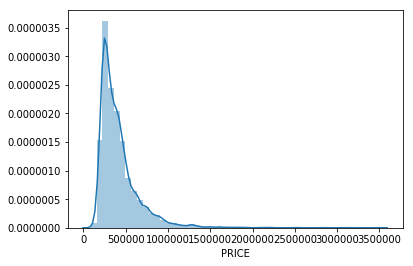

In [63]:
%matplotlib inline
sns.distplot(y_train)

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\micha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


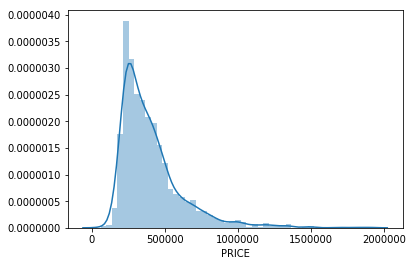

In [64]:
sns.distplot(y_test)

C:\Users\micha\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\micha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


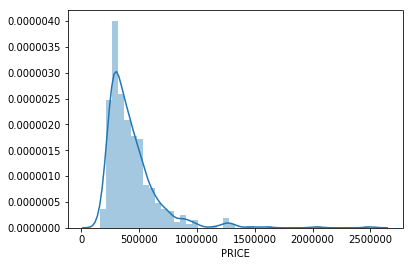

In [65]:
sns.distplot(y_real)

### Q10. Use seaborn to plot count plot of categorical features for X_train, X_test, and X_real. (3 points)

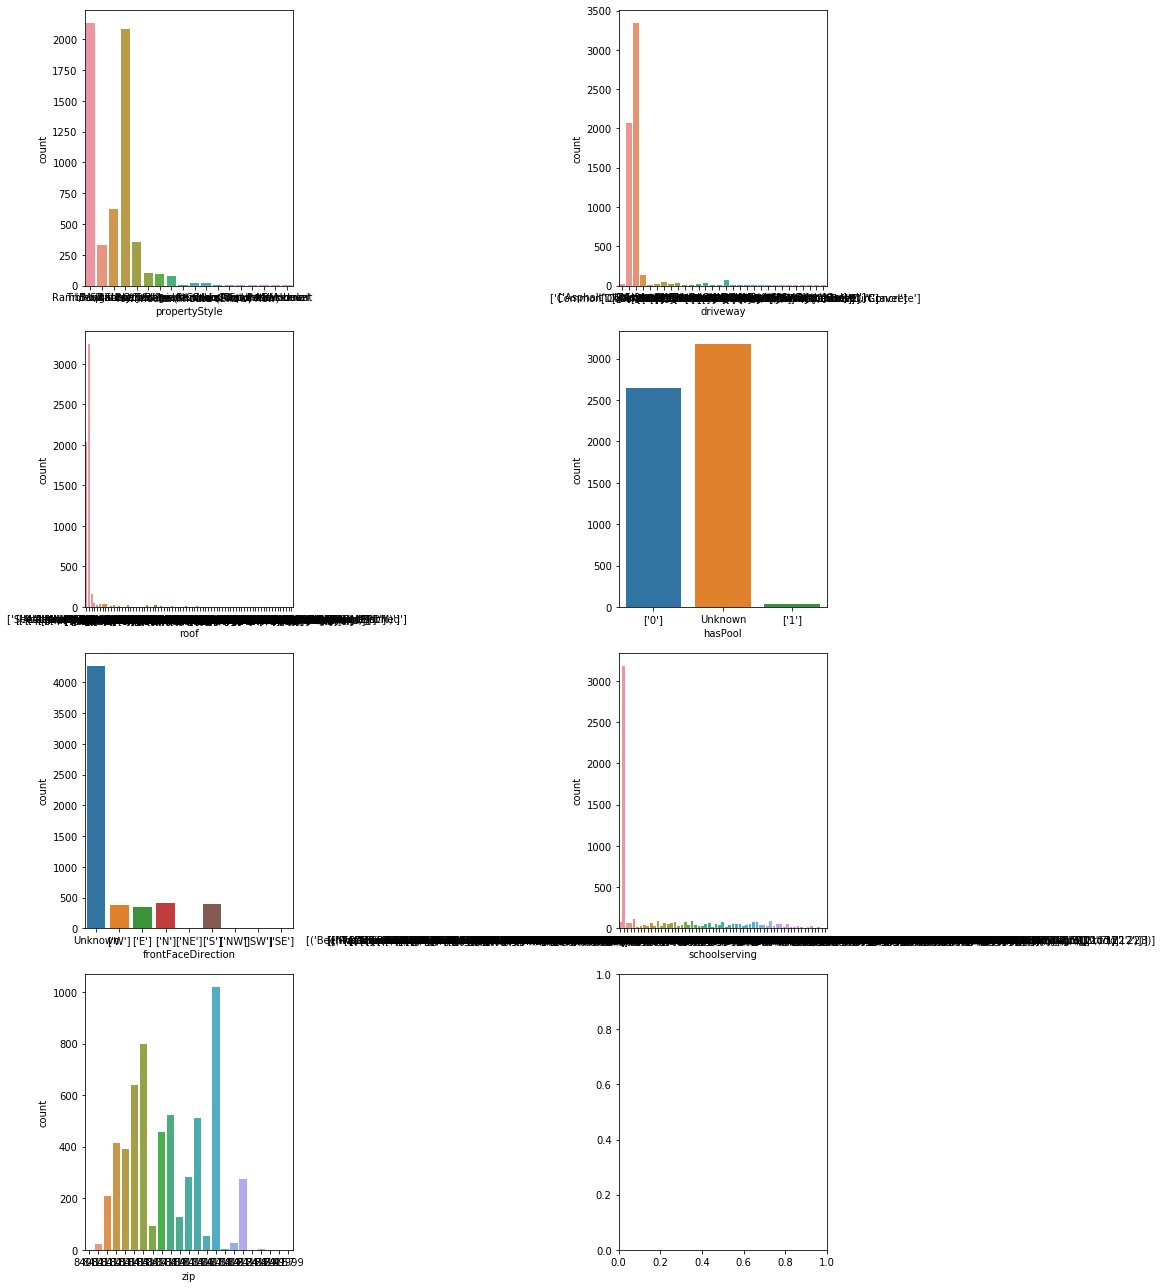

In [66]:
fig, axs = plt.subplots(4, 2, figsize = (16,18))
axslist=[ax for y in axs for ax in y]
for i in range(7):
    sns.countplot(X_train[cat_cols[i]],ax=axslist[i])
fig.tight_layout()   

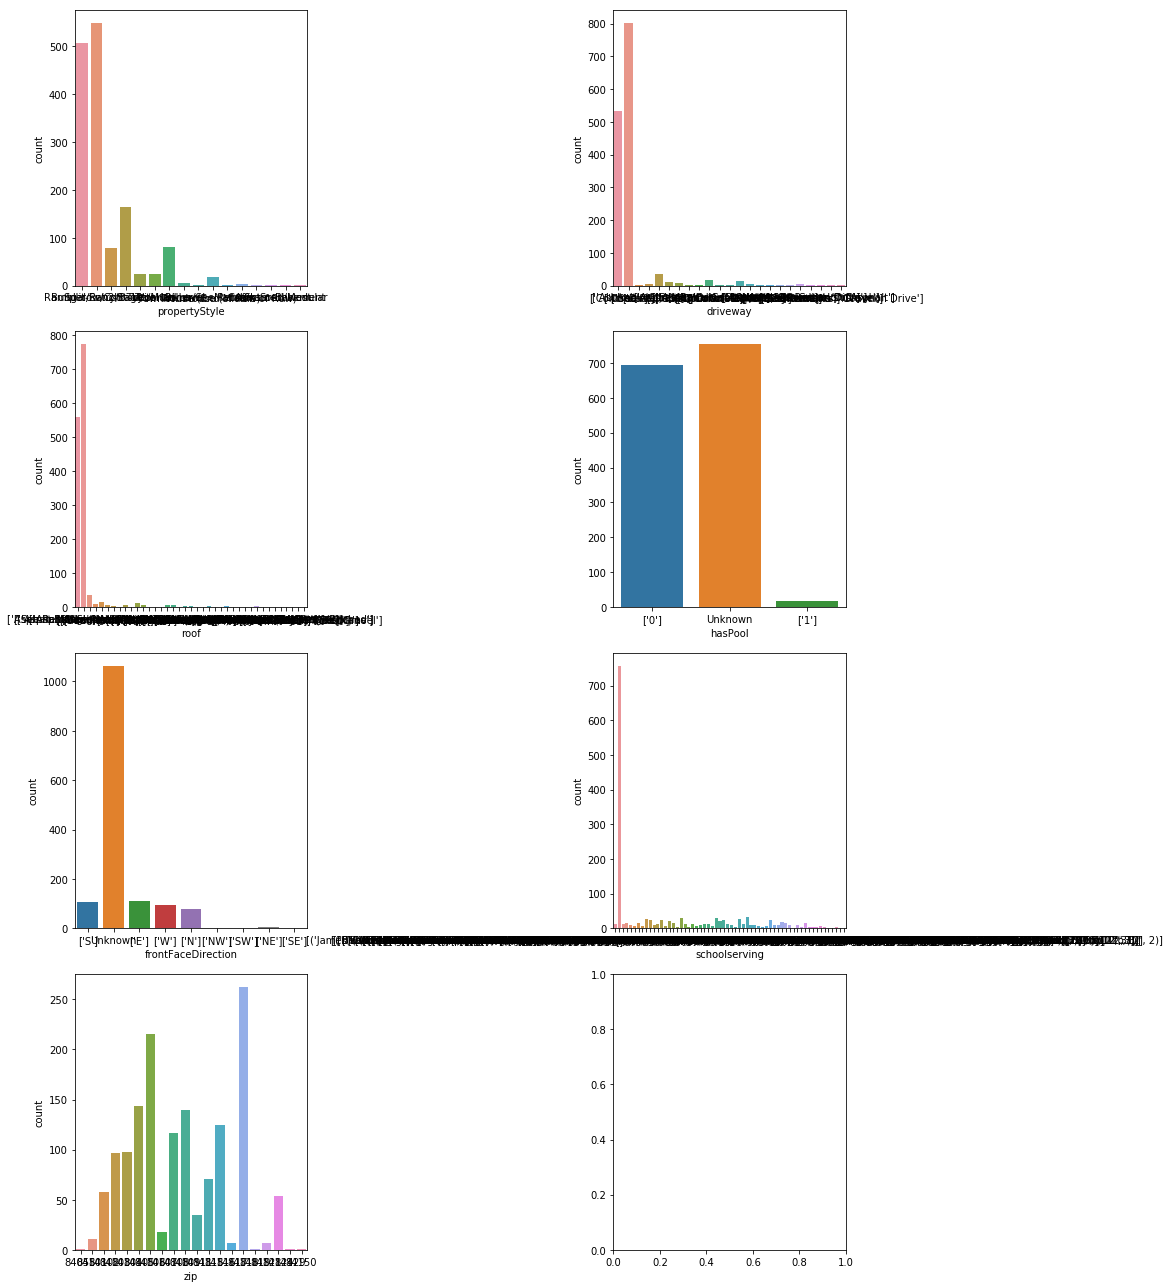

In [67]:
fig, axs = plt.subplots(4, 2, figsize = (16,18))
axslist=[ax for y in axs for ax in y]
for i in range(7):
    sns.countplot(X_test[cat_cols[i]],ax=axslist[i])
fig.tight_layout() 

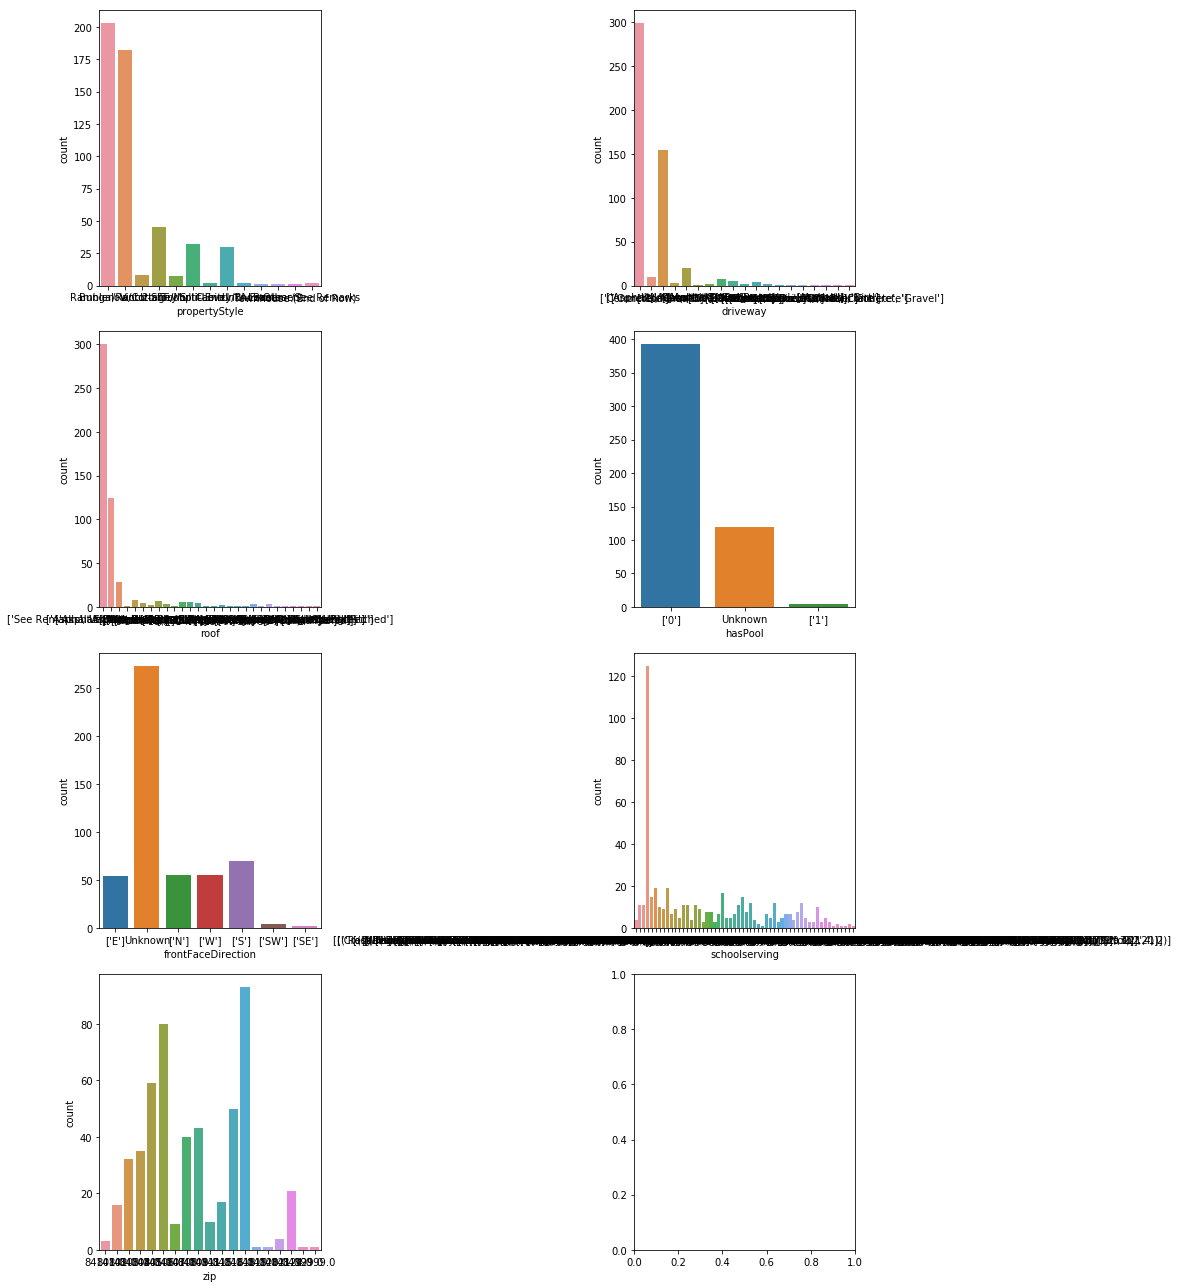

In [68]:
fig, axs = plt.subplots(4, 2, figsize = (16,18))
axslist=[ax for y in axs for ax in y]
for i in range(7):
    sns.countplot(X_real[cat_cols[i]],ax=axslist[i])
fig.tight_layout() 

### Q11. Change the data type of 'zip' of X_train, X_test, and X_real to 'int64'. (2 points)

In [69]:
X_train['zip'] = X_train['zip'].apply(int)
X_test['zip'] = X_test['zip'].apply(int)
X_real['zip'] = X_real['zip'].apply(int)

C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\micha\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [70]:
X_train[cat_cols].dtypes

propertyStyle         object
driveway              object
roof                  object
hasPool               object
frontFaceDirection    object
schoolserving         object
zip                    int64
dtype: object

### Q12. Train your model to predict price using either one of the three alogrithms: Xgboost, Lightgbm, or CatBoost. (20 points)
Note 1:

1. use early stopping when training.
2. use your own parameters.
3. use Root Mean Squared Error (RMSE) as your objective..
4. print out the training time.
5. predict on X_test, and print the RMSE and $R^2$.

Note 2:

To calculate mean squared error and $R^2$, use

> `from math import sqrt
RMSE = sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)`

In [71]:
from catboost import CatBoost, Pool
train_pool = Pool(X_train_lab, y_train)

valid_pool = Pool(X_test_lab, y_test)

In [72]:
params_cgb = { 'objective' : 'RMSE',
              'iterations':2000,
              'learning_rate' : 0.02
             }

In [73]:
model_cgb_cat = CatBoost(params_cgb)

#train the model

%time model_cgb_cat.fit(X = X_train, y = y_train, eval_set = (X_test, y_test), cat_features = cat_cols, early_stopping_rounds = 100, verbose_eval = 100)

0:	learn: 242485.8482532	test: 211987.5135057	best: 211987.5135057 (0)	total: 34.4ms	remaining: 1m 8s
100:	learn: 115301.9907759	test: 93935.2525651	best: 93935.2525651 (100)	total: 2.58s	remaining: 48.4s
200:	learn: 94108.9818540	test: 85111.6401098	best: 85111.6401098 (200)	total: 5.11s	remaining: 45.8s
300:	learn: 85504.3005795	test: 83064.8027124	best: 83022.2797369 (297)	total: 7.96s	remaining: 44.9s
400:	learn: 79963.1057565	test: 80984.3253497	best: 80984.3253497 (400)	total: 10.9s	remaining: 43.6s
500:	learn: 75725.1774407	test: 79394.5066816	best: 79394.5066816 (500)	total: 13.7s	remaining: 40.9s
600:	learn: 71873.8694360	test: 77868.3868520	best: 77868.3868520 (600)	total: 16.5s	remaining: 38.3s
700:	learn: 68852.7978592	test: 76722.6954733	best: 76722.6954733 (700)	total: 19.2s	remaining: 35.5s
800:	learn: 66358.6971877	test: 75940.4794753	best: 75940.4794753 (800)	total: 21.6s	remaining: 32.4s
900:	learn: 64266.4094886	test: 75513.6124171	best: 75513.6124171 (900)	total: 24

In [74]:
y_pred_cgb_cat =  model_cgb_cat.predict(X_test, prediction_type='RawFormulaVal')

r2_cgb = r2_score(y_test, y_pred_cgb_cat)

print(f'RMSE: {sqrt(mean_squared_error(y_test, y_pred_cgb_cat))}')  #RMSE or MSE
print(f'R-Sqaured: {r2_cgb}')

RMSE: 73841.11094395407
R-Sqaured: 0.8816290644269236


### Q13. Predict housing prices using your model just trained on X_real, and print out RMSE. (4 points)

In [75]:
y_pred_cgb_cat_2 =  model_cgb_cat.predict(X_real_lab, prediction_type='RawFormulaVal')

r2_cgb = r2_score(y_real, y_pred_cgb_cat_2)

print(f'RMSE: {sqrt(mean_squared_error(y_real, y_pred_cgb_cat_2))}')  #RMSE or MSE
print(f'R-Sqaured: {r2_cgb}')

RMSE: 137882.01648018704
R-Sqaured: 0.6488661502996567


## Bonus

You can try to build a model to predict the prices, and after I verify all your codes, if your performance on the real data (X_real, y_real) is the best in class, you will get 30 extra points, if your performace ranks the second, you will get 20 extra points, and the third place earns 10 extra points.

**Good luck and thanks for taking my class this semester!**